# Аналіз набору даних новобудов у місті Київ

Для створення актуального набору даних із достатньою кількістю категоріальних критеріїв було створено скрапер за допомогою технології Puppeteer.

Дані збираються з веб-сайту lun.ua - найпопулярнішого агрегатору даних про новобудови в Україні.

Для аналізу набору даних використовується бібліотека pandas.

Ціллю збору даних є використання їх для тренування нейронної мережі яка моделює вартість заданого обʼєкту нерухомості із певними характеристками.

#### Словник

Характеристики обʼєкту (англ. Features) - характеристики з яких будуть обрані залежні та незалежні змінні для тренування моделі для знаходження залежності незалежних змінних від залежних.

Форма (англ. Shape) - описана через формат (N, M) де N - кількість рядків, M - кількість комірок

Теплова карта (англ. Heatmap) - формат візуалізації даних кореляції між характеристиками набору даних

#### Предметна Область

##### Залежні змінні/ Незалежні змінні

Залежною змінною є ціна на обʼєкт нерухомості.
Незалежними змінними є множина характеристик обʼєкту нерухомості що включає в себе числові значення та категоріальні дані.

## Ініціалазація бібліотеки Pandas

In [248]:
import pandas as pd
# бібліотека використовується для візуалізації характеристик набору даних та візуалізацій залежності між змінними
import matplotlib.pylab as plt
# бібліотека для візуалізації кореляції між характеристиками у вигляді теплової карти
import seaborn as sns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Приклад записів з набору даних

In [249]:
df = pd.read_csv('./real-estate.csv')
df.shape

(3459, 17)

In [250]:
df.head(3)

,residence,developer,attributes/class,attributes/construction_technology,attributes/walls,attributes/insulation,attributes/heating,attributes/num_apartments,attributes/state,attributes/protected_area,attributes/parking,financials/installmentPlan,financials/installmentPlanTerm,pricePerUnit,price,area,rooms
0,ЖК Montreal House,Alliance Novobud,бізнес,монолітно-каркасна,цегла,мінеральна вата,автономне (в будинку),328,без ремонту,від авто та сторонніх,підземний з ліфтом (187 паркомісць),True,1.0,116825.0,5023475.0,43,1
1,ЖК Montreal House,Alliance Novobud,бізнес,монолітно-каркасна,цегла,мінеральна вата,автономне (в будинку),328,без ремонту,від авто та сторонніх,підземний з ліфтом (187 паркомісць),True,1.0,116825.0,6308550.0,54,1
2,ЖК Montreal House,Alliance Novobud,бізнес,монолітно-каркасна,цегла,мінеральна вата,автономне (в будинку),328,без ремонту,від авто та сторонніх,підземний з ліфтом (187 паркомісць),True,1.0,116825.0,5958075.0,51,1


## Нормалізація набору даних

### Пусті значення

In [251]:
df.isna().sum()

residence                                0
developer                              426
attributes/class                        14
attributes/construction_technology       0
attributes/walls                         0
attributes/insulation                    0
attributes/heating                       0
attributes/num_apartments               10
attributes/state                         0
attributes/protected_area               10
attributes/parking                       0
financials/installmentPlan             572
financials/installmentPlanTerm        2204
pricePerUnit                          1276
price                                 1276
area                                     0
rooms                                    0
dtype: int64

In [252]:
## фільтрація новобудов без ціни
df = df.loc[~df['price'].isna()]

### Дублікати

In [253]:
df.loc[df.duplicated()]

,residence,developer,attributes/class,attributes/construction_technology,attributes/walls,attributes/insulation,attributes/heating,attributes/num_apartments,attributes/state,attributes/protected_area,attributes/parking,financials/installmentPlan,financials/installmentPlanTerm,pricePerUnit,price,area,rooms
4,ЖК Montreal House,Alliance Novobud,бізнес,монолітно-каркасна,цегла,мінеральна вата,автономне (в будинку),328,без ремонту,від авто та сторонніх,підземний з ліфтом (187 паркомісць),True,1.0,116825.0,6308550.0,54,1
12,ЖК Montreal House,Alliance Novobud,бізнес,монолітно-каркасна,цегла,мінеральна вата,автономне (в будинку),328,без ремонту,від авто та сторонніх,підземний з ліфтом (187 паркомісць),True,1.0,106750.0,9394000.0,88,2
13,ЖК Montreal House,Alliance Novobud,бізнес,монолітно-каркасна,цегла,мінеральна вата,автономне (в будинку),328,без ремонту,від авто та сторонніх,підземний з ліфтом (187 паркомісць),True,1.0,106750.0,9394000.0,88,2
28,ЖК LUCKY LAND,DIM,комфорт,монолітно-каркасна,керамоблок,мінеральна вата,індивідуальне (в квартирі),5183,"без ремонту, з ремонтом",від авто та сторонніх,"гостьовий (2500 паркомісць), підземний з ліфто...",True,3.0,66425.0,1859900.0,28,1
35,ЖК LUCKY LAND,DIM,комфорт,монолітно-каркасна,керамоблок,мінеральна вата,індивідуальне (в квартирі),5183,"без ремонту, з ремонтом",від авто та сторонніх,"гостьовий (2500 паркомісць), підземний з ліфто...",True,3.0,66425.0,3586950.0,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,ЖК Оберіг-2,Київміськбуд,комфорт,монолітно-каркасна,"цегла, газоблок (газобетон)",мінеральна вата,централізоване,820 (2 будинки),без ремонту,ні,"гостьовий, підземний",True,NaN,40550.0,1540900.0,38,1
2854,ЖК Оберіг-2,Київміськбуд,комфорт,монолітно-каркасна,"цегла, газоблок (газобетон)",мінеральна вата,централізоване,820 (2 будинки),без ремонту,ні,"гостьовий, підземний",True,NaN,40550.0,1581450.0,39,1
2866,ЖК Оберіг-2,Київміськбуд,комфорт,монолітно-каркасна,"цегла, газоблок (газобетон)",мінеральна вата,централізоване,820 (2 будинки),без ремонту,ні,"гостьовий, підземний",True,NaN,36450.0,2515050.0,69,2
2871,ЖК Оберіг-2,Київміськбуд,комфорт,монолітно-каркасна,"цегла, газоблок (газобетон)",мінеральна вата,централізоване,820 (2 будинки),без ремонту,ні,"гостьовий, підземний",True,NaN,36950.0,2771250.0,75,3


In [254]:
## очистка дублікатів
df = df.loc[~df.duplicated()].reset_index(drop=True).copy()

In [255]:
df.shape

(1827, 17)

### Приведення типів

In [256]:
df["attributes/num_apartments"] = pd.to_numeric(df["attributes/num_apartments"], errors='coerce')

In [257]:
df.dtypes

residence                              object
developer                              object
attributes/class                       object
attributes/construction_technology     object
attributes/walls                       object
attributes/insulation                  object
attributes/heating                     object
attributes/num_apartments             float64
attributes/state                       object
attributes/protected_area              object
attributes/parking                     object
financials/installmentPlan             object
financials/installmentPlanTerm        float64
pricePerUnit                          float64
price                                 float64
area                                    int64
rooms                                   int64
dtype: object

## Ознайомлення із набором даних

### Форма

In [258]:
df.shape

(1827, 17)

### Типи даних

In [259]:
df.dtypes

residence                              object
developer                              object
attributes/class                       object
attributes/construction_technology     object
attributes/walls                       object
attributes/insulation                  object
attributes/heating                     object
attributes/num_apartments             float64
attributes/state                       object
attributes/protected_area              object
attributes/parking                     object
financials/installmentPlan             object
financials/installmentPlanTerm        float64
pricePerUnit                          float64
price                                 float64
area                                    int64
rooms                                   int64
dtype: object

### Cтатистика

In [260]:
df.describe()

,attributes/num_apartments,financials/installmentPlanTerm,pricePerUnit,price,area,rooms
count,1452.000000,830.000000,1827.000000,1.827000e+03,1827.000000,1827.000000
mean,1530.763085,2.851807,69474.603175,5.778772e+06,79.166940,2.099617
std,1879.105511,1.658684,40890.805075,5.886273e+06,36.437752,1.022172
min,9.000000,1.000000,23450.000000,2.187000e+05,3.000000,1.000000
25%,321.000000,2.000000,40525.000000,2.775825e+06,51.000000,1.000000
50%,724.000000,2.000000,57275.000000,4.092525e+06,74.000000,2.000000
75%,1898.000000,3.000000,83325.000000,6.800938e+06,98.000000,3.000000
max,8339.000000,7.000000,333700.000000,8.342500e+07,278.000000,5.000000


### Характеристики новобудов

#### Всі характеристики

In [261]:
pd.DataFrame(data=df.columns, columns=['Характеристка обʼєкту нерухомості'])

,Характеристка обʼєкту нерухомості
0,residence
1,developer
2,attributes/class
3,attributes/construction_technology
4,attributes/walls
5,attributes/insulation
6,attributes/heating
7,attributes/num_apartments
8,attributes/state
9,attributes/protected_area


#### Забудовник

In [262]:
pd.DataFrame(data=df.developer.unique(), columns=['Забудовник'])

,Забудовник
0,Alliance Novobud
1,DIM
2,УМК
3,KSM-GROUP
4,РІЕЛ
5,IB Alliance
6,Stolitsa Group
7,Nice Development
8,Інтергал-Буд
9,Royal House


#### Клас новобудови

In [263]:
pd.DataFrame(data=df['attributes/class'].unique(), columns=['Клас новобудови'])

,Клас новобудови
0,бізнес
1,комфорт
2,преміум
3,економ


#### Технологія будівництва

In [264]:
pd.DataFrame(data=df['attributes/construction_technology'].unique(), columns=['Технологія будівництва'])

,Технологія будівництва
0,монолітно-каркасна
1,"цегляна, монолітно-каркасна"
2,невідомо
3,панельна
4,"цегляна, монолітно-каркасна, панельна"
5,цегляна


#### Матеріал стін

In [265]:
pd.DataFrame(data=df['attributes/walls'].unique(), columns=['Матеріал стін'])

,Матеріал стін
0,цегла
1,керамоблок
2,"цегла, газоблок (газобетон)"
3,газоблок (газобетон)
4,"газоблок (газобетон), керамоблок"
5,залізобетон
6,"керамзитоблок (керамзитобетон), газоблок (газо..."
7,керамзитоблок (керамзитобетон)
8,"цегла, керамоблок"
9,"газоблок (газобетон), залізобетон, цегла"


#### Утелпення стін

In [266]:
pd.DataFrame(data=df['attributes/insulation'].unique(), columns=['Утелпення стін'])

,Утелпення стін
0,мінеральна вата
1,пінополістирол (пінопласт)
2,базальтова вата (базальтова плита)
3,"мінеральна вата, пінополістирол (пінопласт)"
4,"пінополістирол (пінопласт), мінеральна вата"
5,без утеплення
6,"пінополістирол (пінопласт), базальтова вата (б..."


#### Опалення

In [267]:
pd.DataFrame(data=df['attributes/heating'].unique(), columns=['Опалення'])

,Опалення
0,автономне (в будинку)
1,індивідуальне (в квартирі)
2,централізоване
3,"автономне (в будинку), централізоване"
4,"автономне (в будинку), індивідуальне (в квартирі)"


#### Стан ремонту

In [268]:
pd.DataFrame(data=df['attributes/state'].unique(), columns=['Стан ремонту'])

,Стан ремонту
0,без ремонту
1,"без ремонту, під ремонт"
2,"без ремонту, з ремонтом"
3,"під ремонт, з ремонтом"
4,з чорновим ремонтом
5,"без ремонту, під ремонт, з ремонтом"
6,під ремонт
7,з ремонтом
8,"без ремонту, з чорновим ремонтом"
9,"з ремонтом, з чорновим ремонтом"


#### Закрита територія

In [269]:
pd.DataFrame(data=df['attributes/protected_area'].unique(), columns=['Закрита територія'])

,Закрита територія
0,від авто та сторонніх
1,від автомобілів
2,ні
3,невідомо


#### Паркінг

In [270]:
pd.DataFrame(data=df['attributes/parking'].unique(), columns=['Паркінг'])

,Паркінг
0,підземний з ліфтом (187 паркомісць)
1,підземний
2,"гостьовий (2500 паркомісць), підземний з ліфто..."
3,"гостьовий, підземний"
4,підземний з ліфтом
5,"гостьовий, підземний (310 паркомісць)"
6,гостьовий
7,наземний багаторівневий
8,підземний з ліфтом (750 паркомісць)
9,наземний багаторівневий (1787 паркомісць)


#### Термін розстрочки

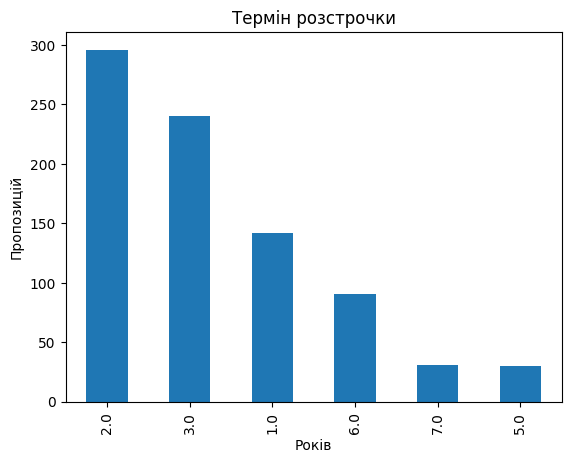

In [271]:
ax = df['financials/installmentPlanTerm'].value_counts().head(10).plot(kind='bar', title='Термін розстрочки')

ax.set_xlabel('Років')
ax.set_ylabel('Пропозицій')

plt.show()

#### Ціна за квадратний метр

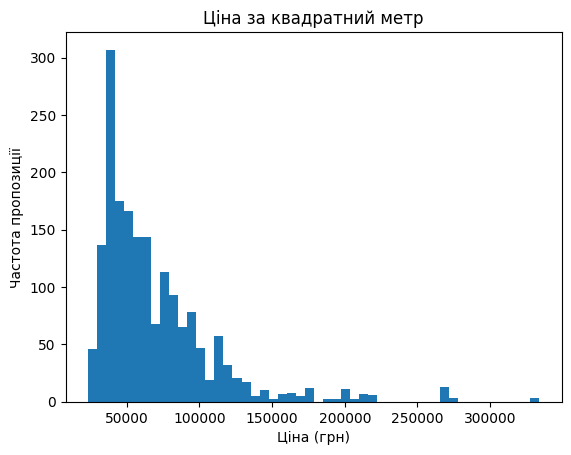

In [272]:
ax = df.copy().sort_values(by='pricePerUnit')['pricePerUnit'].plot(kind='hist', bins=50, title='Ціна за квадратний метр')

ax.set_xlabel('Ціна (грн)')
ax.set_ylabel('Частота пропозиції')

plt.show()

#### Ціна новобудови

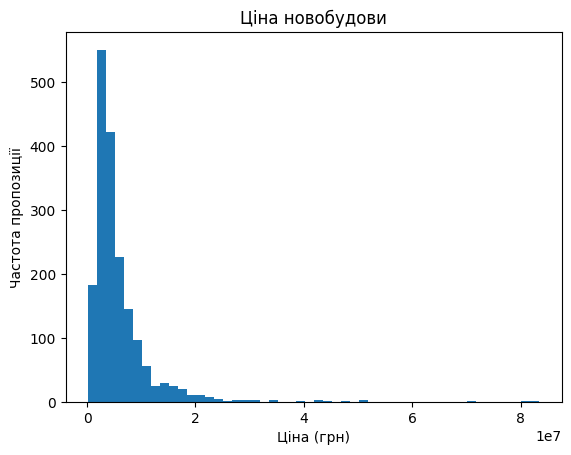

In [273]:
ax = df.copy().sort_values(by='price')['price'].plot(kind='hist', bins=50, title='Ціна новобудови')

ax.set_xlabel('Ціна (грн)')
ax.set_ylabel('Частота пропозиції')

plt.show()

#### Житлова площа

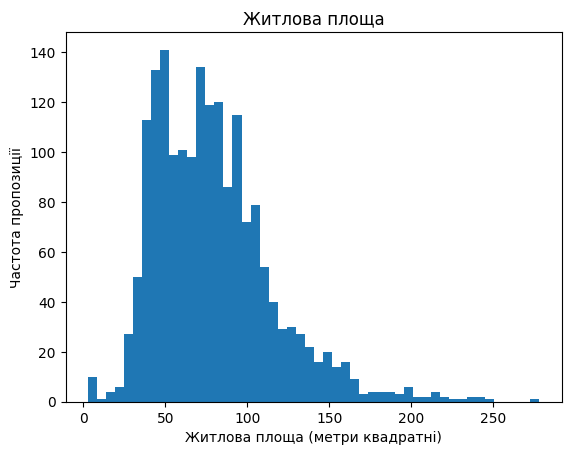

In [274]:
ax = df.copy().sort_values(by='area')['area'].plot(kind='hist', bins=50, title='Житлова площа')

ax.set_xlabel('Житлова площа (метри квадратні)')
ax.set_ylabel('Частота пропозиції')

plt.show()

#### Кількість кімнат

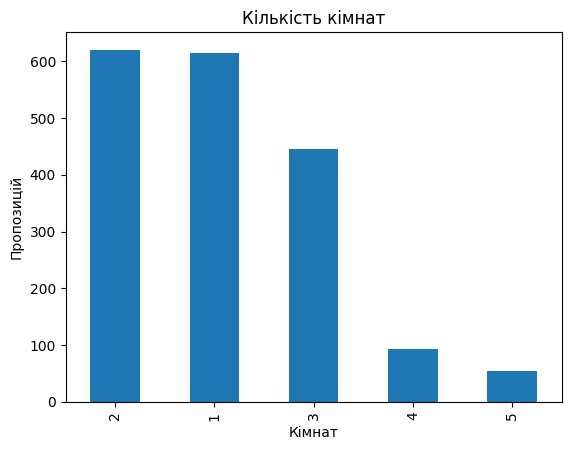

In [275]:
ax = df['rooms'].value_counts().head(10).plot(kind='bar', title='Кількість кімнат')

ax.set_xlabel('Кімнат')
ax.set_ylabel('Пропозицій')

plt.show()

#### Кількість квартир у новобудові

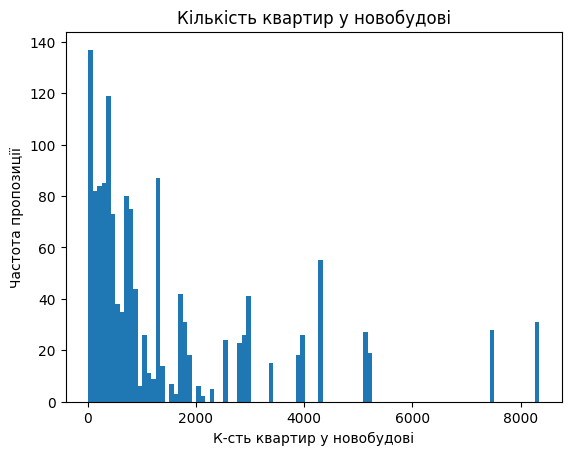

In [276]:
ax = df.copy().sort_values(by='attributes/num_apartments')['attributes/num_apartments'].plot(kind='hist', bins=100, title='Кількість квартир у новобудові')

ax.set_xlabel('К-сть квартир у новобудові')
ax.set_ylabel('Частота пропозиції')

plt.show()

## Залежність між залежними та незалежними змінними (числові значення)

In [ ]:
sns.pairplot(df, vars=[
    'price',
    'attributes/num_apartments',
    'financials/installmentPlanTerm',
    'pricePerUnit',
    'area',
    'rooms'
], hue='attributes/construction_technology')

plt.show()

In [ ]:
racorr = df[[
    'price',
    'attributes/num_apartments',
    'financials/installmentPlanTerm',
    'pricePerUnit',
    'area',
    'rooms'
]].dropna().corr()

sns.heatmap(data=racorr, annot=True)

plt.show()